# Calculate everything for all materials

In [1]:
#make heterostructure
#%%
#Import a lot of stuff
import numpy as np
import matplotlib.pyplot as plt
from qeh import make_heterostructure, Heterostructure
from default_parameters import get_thickness, get_intermass
import ase.units

#plot design
from matplotlib import rcParams
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20 

Hartree = ase.units.Hartree#Hartree energy
Bohr = ase.units.Bohr#Bohr radius

# Choose number of padding layers.
# Can experiment with and without encapsulating (padding) in BN
nPadding=0
#material list
#material_List=['H-MoS2','H-MoSe2','H-MoTe2','H-WS2','H-WSe2']
material_List=['H-MoS2','H-MoSe2','H-WS2','H-WSe2']
#material_List=['H-MoS2']
n_materials=len(material_List)
range_materials=range(n_materials)
binding_Energies_Mat=np.zeros((n_materials,n_materials))
index_Vec=[(ie,jh) for ie in range_materials for jh in range_materials]
#initialize
W_ee_Matrix=[[]]*n_materials**2
W_Exciton_Matrix=[[]]*n_materials**2
MaterialComb=[[]]*n_materials**2
dielectric_func_Matrix=[[]]*n_materials**2

count=-1
#print(binding_Energies_Mat)
for ie in range_materials:
    for jh in range_materials:
        count+=1
        #Choose ndoped material and pdoped
        e_layer_formula=material_List[ie]
        h_layer_formula=material_List[jh]
        
        #material combination
        MaterialComb[count]=e_layer_formula[2:]+', '+h_layer_formula[2:]
        
        #layer thicknesses from the middle of one layer to another
        d_BN = get_thickness('BN')  # hBN-hBN distance#3.22 før
        d_e_layer = get_thickness(e_layer_formula)
        d_e_BN = (d_BN+d_e_layer)/2  # MoS2-hBN distance
        d_h_layer = get_thickness(h_layer_formula)
        d_h_BN = (d_BN+d_h_layer)/2  # WSe2-hBN distance
        #list of layer thicknesses
        d= [d_BN]*(nPadding-1) + [d_e_BN]*2 + [d_BN]*(3-1) + [d_h_BN]*2 + [d_BN]*(nPadding-1)
        #layers
        layers = ['{}BN'.format(nPadding), e_layer_formula, '3BN', h_layer_formula, '{}BN'.format(nPadding)]

        # hs = make_heterostructure(layers) #could be used. We choose to input some parameters ourselves to get a feeling for what is going on
        hs = Heterostructure(structure=layers,  # set up structure
                                d=d,                         # layer distance array
                                include_dipole=True,
                                wmax=0,                      # only include \omega=0
                                qmax=1,                      # q grid up to 1 Ang^{-1}
                                d0=0)                     # width of single layer (only used for monolayer calculation), so currently set to 0
        # %%
        # # Get Macroscropic Dielectric function - this is a test that things look reasonable
        q, w, epsM = hs.get_macroscopic_dielectric_function()
        # # plot
        plt.plot(q, epsM.real)
        plt.xlim(0, 1)
        plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
        plt.ylabel(r'$\epsilon_M(q, \omega=0)$', fontsize=20)
        plt.title('Static dielectric function', fontsize=20)
        plt.savefig('./plots/eps_vdWH_{}_{}_{}Padding.svg'.format(e_layer_formula[2:],h_layer_formula[2:],nPadding))
        #plt.close()
        # plt.show()
        #save
        dielectric_func_Matrix[count]=epsM

        # %%
        # Calculate screened potential W(q, \omega)
        W_e_layer = hs.get_screened_potential(layer=nPadding)
        W_h_layer = hs.get_screened_potential(layer=nPadding+4)
        
        W_ee_Matrix[count] = W_e_layer #save
        
        q = hs.q_abs / Bohr # get q-array (momentum transfer range) in Ångstrom.
        indexQ_start=4
        # plot together
        plt.plot(q[indexQ_start:], W_e_layer[indexQ_start:,].real)
        plt.plot(q[indexQ_start:], W_h_layer[indexQ_start:,].real,'--')
        # plt.xlim(0, 1)
        plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
        plt.ylabel(r'$U(q, \omega=0)$', fontsize=20)
        plt.title('Screened potential', fontsize=20)
        plt.legend([e_layer_formula[2:],h_layer_formula[2:]], fontsize=20)
        plt.savefig('./plots/VScr_vdWH_{}_{}_{}.svg'.format(e_layer_formula[2:],h_layer_formula[2:],nPadding))
        # plt.show()

        # %%
        # Plot exciton screened potential
        # 2*number of layers, first is spin up
        # but no electrons in BN-layers
        # consider single electron in n-doped layer
        # consider single hole in p-dopedlayer
        zeroPadding=np.zeros(2*nPadding)
        hl_array = np.hstack([zeroPadding, np.array([1., 0.]), np.zeros(6), np.array([0., 0.]),zeroPadding ])
        el_array = np.hstack([zeroPadding, np.array([0., 0.]), np.zeros(6), np.array([1., 0.]),zeroPadding ])

        # Calculate exciton screened 
        _,W_Exciton,_ = hs.get_exciton_screened_potential(e_distr=el_array, h_distr=hl_array)
        print(W_Exciton)
        #plot
        plt.plot(q[indexQ_start:], W_Exciton[indexQ_start:].real)
        # plt.xlim(0, 1)
        plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
        plt.ylabel(r'$W(q, \omega=0)$', fontsize=20)
        plt.title('Screened exciton potential', fontsize=20)
        plt.savefig('./plots/VScr_Exciton_vdWH_{}_{}_{}.svg'.format(e_layer_formula[2:],h_layer_formula[2:],nPadding))
        # plt.show()
        #save exciton potential
        W_Exciton_Matrix[count]=W_Exciton
        #exciton binding energies
        # The effective interlayer exciton mass is calculated as:
        # 1/m*=1/me*+1/mh*.
        # me* and mh* can be found in c2db,
        # but we import them from the default_parameters.py.
        ee, ev = hs.get_exciton_binding_energies(eff_mass=get_intermass(e_layer_formula, h_layer_formula),
                                                 e_distr=el_array,
                                                 h_distr=hl_array)

        print('The interlayer exciton binding energy is: {:0.4f} eV'.format(-ee[0].real))
        print('The (first 5) interlayer exciton binding energies are:'.format(-ee[0].real))
        for i in range(0,5):
            print('{:0.4f} eV'.format(-ee[i].real))
        m=5
        plt.plot(range(0,m), ee[:m].real)
        plt.xlabel(r'$n$)', fontsize=20)
        plt.ylabel(r'$-E_b(n)$', fontsize=20)
        plt.title('Lowest exciton eigenenergies',fontsize=20)
        plt.savefig('./plots/binding_energies_vdWH_{}_{}_{}.svg'.format(e_layer_formula[2:],h_layer_formula[2:],nPadding))
        # plt.show()
        #save binding energy
        binding_Energies_Mat[ie,jh]=-ee[0].real
bindEnVec=binding_Energies_Mat.reshape(n_materials**2,1)
print(binding_Energies_Mat)

Calculating full chi
10.0%
20.0%
30.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
90.0%


: 

: 

In [47]:
#save
#data_zip=zip(W_ee_Matrix, W_Exciton_Matrix,MaterialComb ,dielectric_func_Matrix,binding_Energies_Mat)
np.savez('vdWH_{}.npz'.format(nPadding),x1=W_ee_Matrix,x2=W_Exciton_Matrix,x3=dielectric_func_Matrix,x4=binding_Energies_Mat)

In [41]:
with np.load('vdWH_0.npz') as data3:
    data31=data3['x1']
    data32=data3['x2']
    data33=data3['x3']
    data34=data3['x4']
    print(data34)

[[0.19099895 0.18431879 0.19572476 0.18907947]
 [0.18315267 0.17605057 0.18746833 0.18042311]
 [0.19614002 0.18810994 0.20111974 0.19314318]
 [0.18826085 0.18080419 0.19283878 0.18543833]]


# Plot binding energies

In [63]:
bind=[[]]*4
for i in range(4):
    with np.load('vdWH_{}.npz'.format(i)) as data:
        bind[i]=data['x4']
        #print(bind[i])

[[0.19099895 0.18431879 0.19572476 0.18907947]
 [0.18315267 0.17605057 0.18746833 0.18042311]
 [0.19614002 0.18810994 0.20111974 0.19314318]
 [0.18826085 0.18080419 0.19283878 0.18543833]]
[[0.18050315 0.17465837 0.18447171 0.17853875]
 [0.17439282 0.16862715 0.17815561 0.17236579]
 [0.18461479 0.17814611 0.18886028 0.18265676]
 [0.17863936 0.17263772 0.18289069 0.17681569]]
[[0.17024782 0.16469449 0.17320442 0.16792916]
 [0.16453697 0.15915877 0.16777034 0.16287231]
 [0.17311551 0.16761674 0.17669733 0.17125058]
 [0.1678897  0.16272945 0.1712424  0.16604555]]
[[0.16158975 0.15652825 0.16479475 0.159979  ]
 [0.15654227 0.1521594  0.15932561 0.15496412]
 [0.1645547  0.15925073 0.16765012 0.16288091]
 [0.15984849 0.15474145 0.16274767 0.15828345]]


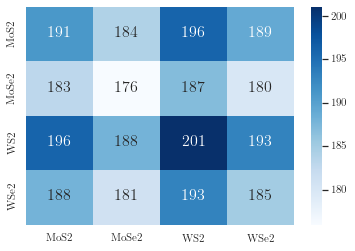

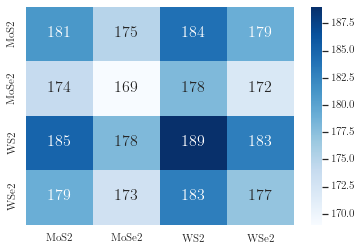

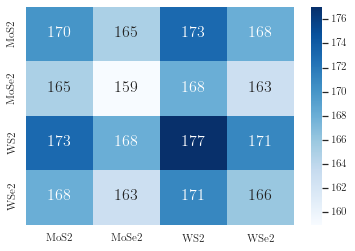

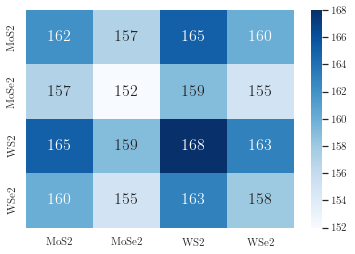

In [64]:
for i in range(4):
    sns.heatmap(np.round(bind[i]*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
    plt.show()

TypeError: Image data of dtype object cannot be converted to float

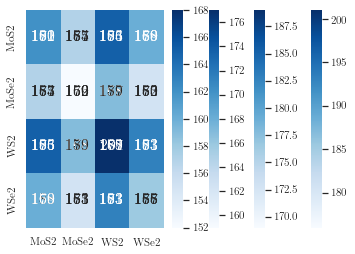

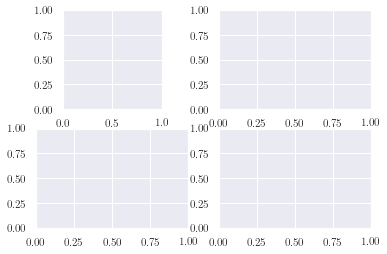

In [66]:
plot0=sns.heatmap(np.round(bind[0]*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
plot1=sns.heatmap(np.round(bind[1]*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
plot2=sns.heatmap(np.round(bind[2]*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
plot3=sns.heatmap(np.round(bind[3]*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)
fig, axs = plt.subplots(2, 2)
axs[0, 0].matshow(plot0)
axs[0, 0].set_title('Axis [0,0]')
axs[0, 1].plot1
axs[0, 1].set_title('Axis [0,1]')
axs[1, 0].plot2
axs[1, 0].set_title('Axis [1,0]')
axs[1, 1].plot3
axs[1, 1].set_title('Axis [1,1]')
#sns.heatmap(np.round(binding_Energies_Mat*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)

# Calculate binding energies

In [45]:
TruthVecMax=bindEnVec==binding_Energies_Mat.max()
TruthVecMax=TruthVecMax.reshape(n_materials**2,1)
max_ind=np.arange(n_materials**2)[TruthVecMax.flatten()][0]
max_index=index_Vec[max_ind]
print('Maximum binding energy: {} eV for e_layer: {} and h_layer {}'.format(binding_Energies_Mat.max(),material_List[max_index[0]],material_List[max_index[1]]))

TruthVecMin=bindEnVec==binding_Energies_Mat[binding_Energies_Mat>0].min()
TruthVecMin=TruthVecMin.reshape(n_materials**2,1)
min_ind=np.arange(n_materials**2)[TruthVecMin.flatten()][0]
min_index=index_Vec[min_ind]
print('Minimum binding energy: {} eV for e_layer: {} and h_layer {}'.format(binding_Energies_Mat[binding_Energies_Mat>0].min(),material_List[min_index[0]],material_List[min_index[1]]))

print(material_List)
print(np.round(binding_Energies_Mat*10**3,1))


Maximum binding energy: 0.1888602809468812 eV for e_layer: H-WS2 and h_layer H-WS2
Minimum binding energy: 0.1686271545629619 eV for e_layer: H-MoSe2 and h_layer H-MoSe2
['H-MoS2', 'H-MoSe2', 'H-WS2', 'H-WSe2']
[[180.5 174.7 184.5 178.5]
 [174.4 168.6 178.2 172.4]
 [184.6 178.1 188.9 182.7]
 [178.6 172.6 182.9 176.8]]


In [3]:
pip install seaborn

     |████████████████████████████████| 292 kB 5.3 MB/s            
     |████████████████████████████████| 11.7 MB 33.7 MB/s            
You should consider upgrading via the '/zhome/54/6/138438/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


<AxesSubplot:>

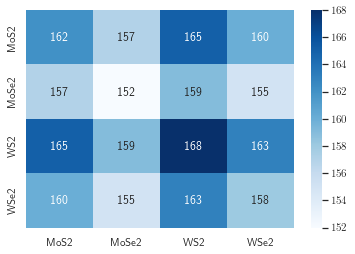

In [24]:
import seaborn as sns; sns.set_theme()
#sns.heatmap(np.round(binding_Energies_Mat*10**3,0),annot=True)
labels=[[]]*n_materials
for i in range(n_materials):
    labels[i]=material_List[i][2:]
    #print(labels)
sns.heatmap(np.round(binding_Energies_Mat*10**3,0),annot=True,cmap='Blues',fmt='g',xticklabels=labels,yticklabels=labels)

In [8]:
#make index vec
range_materials=range(n_materials)
index_Vec=[(ie,jh) for ie in range_materials for jh in range_materials]
print(index_Vec)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


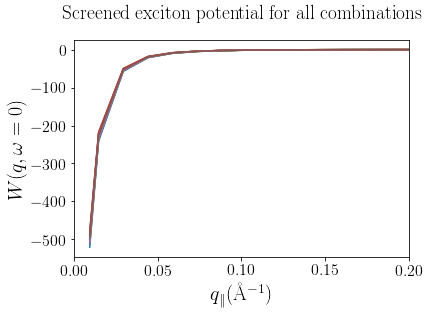

In [45]:
indexQ_start=2
q_reduced=q[indexQ_start:]
W_nonempty=np.zeros(len(q_reduced)).reshape(1,len(q_reduced))
Legend=[[]]*n_materials**2
for i in range(n_materials**2):
    W_Exciton=np.array(W_Exciton_Matrix[i])
    plt.plot(q_reduced, W_Exciton[indexQ_start:].real)
    plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
    plt.ylabel(r'$W(q, \omega=0)$', fontsize=20)
    W_nonempty=np.row_stack((W_nonempty,W_Exciton[indexQ_start:].real))
    Legend[i]=MaterialComb[i]
W_nonempty=W_nonempty[1:]
plt.xlim(0,0.2)
plt.title("Screened exciton potential for all combinations")
plt.savefig('./plots/VScr_Exciton_vdWH_all_combinations_{}.svg'.format(nPadding))
#plt.legend(Legend)
plt.show()

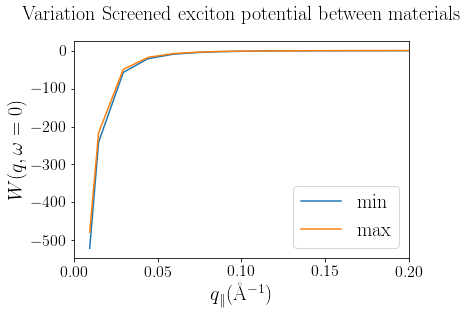

In [46]:
#Nu laver jeg noget, der måske er lidt fjollet, men jeg undersøger, hvad forskellen er mellem de forskellige materiale
#ved til hver q-værdi at finde den hhv. største og mindste potential-værdi og plotte den
W_min=np.min(W_nonempty,axis=0)#take coloum-wise minimum
W_max=np.max(W_nonempty,axis=0)#take coloum-wise minimum
#plot
plt.plot(q_reduced, W_min)
plt.plot(q_reduced, W_max)
plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
plt.ylabel(r'$W(q, \omega=0)$', fontsize=20)
plt.legend(['min','max'], fontsize=20)
plt.xlim(0,0.2)
plt.title('Variation Screened exciton potential between materials', fontsize=20)
plt.savefig('./plots/VScr_Exciton_vdWH_min_and_max_Padding{}.svg'.format(nPadding))

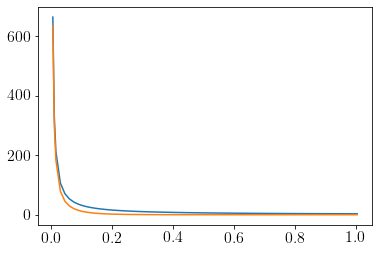

In [75]:
#we would like to plot eq (4) as well
indexQ_start=1
epsMqInv=np.array([1/(epsM[i]*q[i]) for i in range(len(q))])
VS=2*np.pi*epsMqInv
epsMqInv2=np.array([1/(2*q[i]) for i in range(len(q))])
VS2=2*np.pi*epsMqInv2
d_barrier=3*d_BN
VD2=-VS2*np.exp(-d_barrier*q)
plt.plot(q[indexQ_start:], VS2[indexQ_start:].real)
plt.plot(q[indexQ_start:], -VD2[indexQ_start:].real)

# Plot screened potential and screened exciton potential and compare

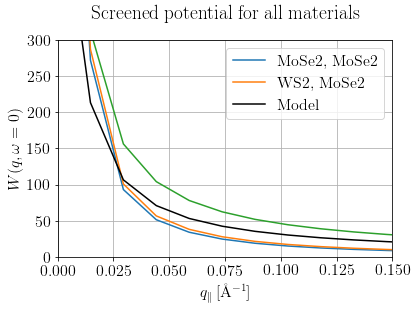

In [217]:
materials=[5,9]
Legend=[[]]*len(materials)
count=0
for i in materials:
    plt.plot(q[indexQ_start:], W_ee_Matrix[i][indexQ_start:].real)
    Legend[count]=MaterialComb[i]
    count+=1
plt.plot(q[indexQ_start:], VS2[indexQ_start:].real,'k-')
#plt.plot(Xdata,VS(Xdata,parameters[0]))
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$W(q, \omega=0)$')
plt.xlim(q[indexQ_start-1],0.2)
plt.xlim(0,0.15)
plt.ylim(0,300)
plt.legend(np.hstack((Legend,np.array(['Model']))))
plt.title("Screened potential for all materials")
#plt.savefig('./plots/VScr_vdWH_all_materials_{}.svg'.format(nPadding))
plt.grid()
plt.show()

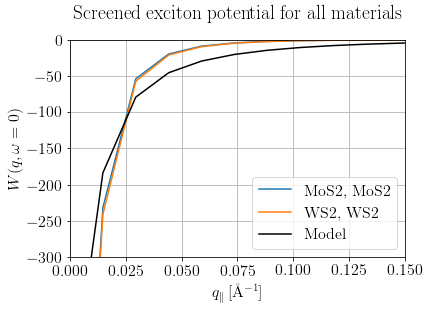

In [203]:
materials=[0,10]
Legend=[[]]*len(materials)
count=0
for i in materials:
    plt.plot(q[indexQ_start:], W_Exciton_Matrix[i][indexQ_start:].real)
    #plt.plot(q[indexQ_start:], -W_ee_Matrix[i][indexQ_start:].real)
    Legend[count]=MaterialComb[i]
    count+=1
plt.plot(q[indexQ_start:], VD2[indexQ_start:].real,'k-')
#plt.plot(q[indexQ_start:], -VS2[indexQ_start:].real,'b-')
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$W(q, \omega=0)$')
#plt.xlim(q[indexQ_start-1],0.2)
#plt.ylim(5,100)
plt.xlim(0,0.15)
plt.ylim(-300,0)
plt.legend(np.hstack((Legend,np.array(['Model']))))
plt.title("Screened exciton potential for all materials")
#plt.savefig('./plots/VScr_vdWH_all_materials_{}.svg'.format(nPadding))
plt.grid()
plt.show()

# Fit eq 4 to data

In [235]:
#data
Qstart=1
Xdata=q[Qstart:]
Ydata=np.array(W_ee_Matrix[0][Qstart:]).flatten()
Y2data=np.array(W_Exciton_Matrix)
#fit functions
def VS(x,eps,n):
    y= 2*np.pi/(eps*x**n)
    return y
#def VD(x,eps):
#    y= VS(x,eps)*np.exp(-d_barrier*q)
#    return y
type(Ydata)

numpy.ndarray

In [230]:
Xdata.shape, Ydata.shape

((47,), (47,))

In [237]:
from scipy.optimize import curve_fit
parameters, covariance = curve_fit(VS, Xdata, Ydata)

In [242]:
print(parameters)
def eps(q):
    return parameters[0]*q**(parameters[1]-1)

[10.07181384  1.45685253]


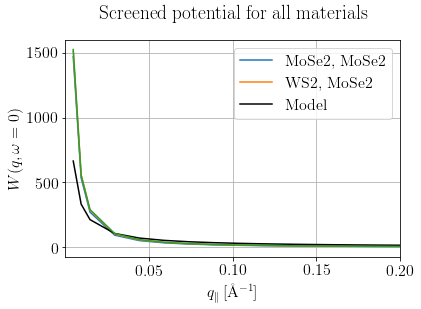

In [240]:
materials=[5,9]
Legend=[[]]*len(materials)
count=0
for i in materials:
    #plt.loglog(q[indexQ_start:], W_ee_Matrix[i][indexQ_start:].real)
    plt.plot(q[indexQ_start:], W_ee_Matrix[i][indexQ_start:].real)
    Legend[count]=MaterialComb[i]
    count+=1
#plt.loglog(q[indexQ_start:], VS2[indexQ_start:].real,'k-')
#plt.loglog(Xdata,VS(Xdata,*parameters))
plt.plot(q[indexQ_start:], VS2[indexQ_start:].real,'k-')
plt.plot(Xdata,VS(Xdata,*parameters))
plt.xlabel(r'$q_\parallel \, [\mathrm{\AA^{-1}}$]')
plt.ylabel(r'$W(q, \omega=0)$')
plt.xlim(q[indexQ_start-1],0.2)
#plt.xlim(0,0.15)
#plt.ylim(0,300)
plt.legend(np.hstack((Legend,np.array(['Model']))))
plt.title("Screened potential for all materials")
#plt.savefig('./plots/VScr_vdWH_all_materials_{}.svg'.format(nPadding))
plt.grid()
plt.show()

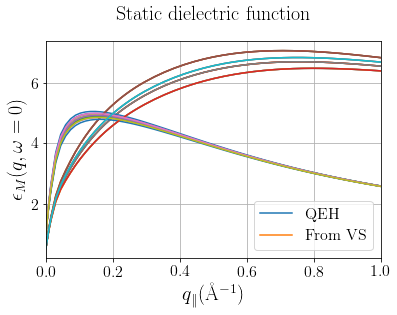

In [245]:
iMOS2MOS2=2
for iMOS2MOS2 in range(15):
    eps_VS=np.array([2*np.pi/W_ee_Matrix[iMOS2MOS2][i]/q[i] for i in range(len(q))])
    eps_VD=np.array([-2*np.pi/W_Exciton_Matrix[iMOS2MOS2][i]/q[i]*np.exp(-d_barrier*q[i]) for i in range(len(q))])
    #print(W_Exciton_Matrix[iMOS2MOS2][W_Exciton_Matrix[iMOS2MOS2]>0])
    #print(min(W_ee_Matrix[iMOS2MOS2].real))
    #print(min(W_ee_Matrix[iMOS2MOS2][-1].real))
    plt.plot(q, dielectric_func_Matrix[iMOS2MOS2].real)
    plt.plot(q,eps_VS.real)
    #plt.plot(q,eps_VD.real) #cannot use this since VD becomes too close to zero
#plt.plot(q,eps(q))
plt.legend(["QEH","From VS"])
plt.xlim(0, 1)
plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
plt.ylabel(r'$\epsilon_M(q, \omega=0)$', fontsize=20)
plt.title('Static dielectric function', fontsize=20)
plt.grid()
plt.show()

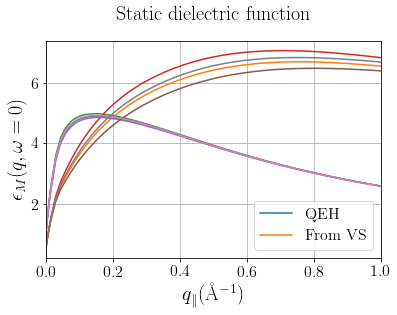

In [169]:
iMOS2MOS2=2
for iMOS2MOS2 in [0,4,8,12]:
    eps_VS=np.array([2*np.pi/W_ee_Matrix[iMOS2MOS2][i]/q[i] for i in range(len(q))])
    eps_VD=np.array([-2*np.pi/W_Exciton_Matrix[iMOS2MOS2][i]/q[i]*np.exp(-d_barrier*q[i]) for i in range(len(q))])
    #print(W_Exciton_Matrix[iMOS2MOS2][W_Exciton_Matrix[iMOS2MOS2]>0])
    #print(min(W_ee_Matrix[iMOS2MOS2].real))
    #print(min(W_ee_Matrix[iMOS2MOS2][-1].real))
    plt.plot(q, dielectric_func_Matrix[iMOS2MOS2].real)
    plt.plot(q,eps_VS.real)
#plt.plot(q,eps_VD.real) #cannot use this since VD becomes too close to zero
plt.legend(["QEH","From VS"])
plt.xlim(0, 1)
plt.xlabel(r'$q_\parallel (\mathrm{\AA^{-1}}$)', fontsize=20)
plt.ylabel(r'$\epsilon_M(q, \omega=0)$', fontsize=20)
plt.title('Static dielectric function', fontsize=20)
plt.grid()
plt.show()

In [122]:
len(W_ee_Matrix[0])
q[4]
np.shape(np.array(W_ee_Matrix))
W_ee_Matrix[0][10]

array([13.63560785-1.87728055e-16j])